In [37]:
import cv2 as cv
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import os
from skimage.transform import resize
from sklearn.ensemble import RandomForestRegressor

In [3]:
imgList = []
segList = []
for file in os.listdir('T0008F001F012/'):
    if file.endswith('tif'):
        imgList.append(file)
    elif file.endswith('npy'):
        segList.append(file)
imgList.sort()
segList.sort()

In [4]:
trainX_List = []
trainY_List = []

In [5]:
for i in range(len(imgList)):
    testImg = cv.imread('T0008F001F012/{}'.format(imgList[i]), -1)
    testImg_Seg = np.load('T0008F001F012/{}'.format(segList[i]))
    testImg_Seg = testImg_Seg[:, :, 0]
    testImg_Seg = -testImg_Seg + 2
    locCoord = np.where(testImg_Seg == 1)
    train_X = np.transpose(np.array(locCoord))
    train_Y = testImg[locCoord]
    trainX_List.append(train_X.copy())
    trainY_List.append(train_Y.copy())

In [6]:
trainX_Total = np.concatenate(trainX_List)
trainY_Total = np.concatenate(trainY_List)

In [10]:
Sampling = np.random.randint(0, high = trainX_Total.shape[0] - 1, size = 100000)
trainX_Total_Sampled = trainX_Total[Sampling, :]
trainY_Total_Sampled = trainY_Total[Sampling]

In [17]:
model = Pipeline([('poly', PolynomialFeatures(degree=4)),
                  ('linear', LinearRegression(fit_intercept=False))])

In [18]:
model = model.fit(trainX_Total, trainY_Total)

In [11]:
wholeCoord = np.where(testImg > -1)

In [19]:
wholeX = np.transpose(np.array(wholeCoord))
wholeY1 = model.predict(wholeX)

In [20]:
emptyTemp1 = np.zeros(testImg.shape, 'float32')

In [21]:
emptyTemp1[wholeCoord] = wholeY1

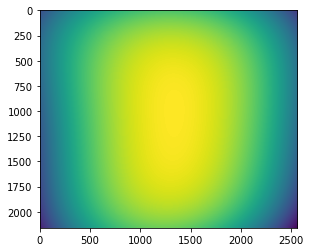

In [22]:
plt.imshow(emptyTemp1)

In [24]:
cv.imwrite('testEmptyTemp.tif', emptyTemp1)

True

In [25]:
correctedImgList = []
emptyTemp = emptyTemp1

In [28]:
for i in range(len(imgList)):
    testImg = cv.imread('T0008F001F012/{}'.format(imgList[i]), -1)
    correctedImgList.append(testImg.astype('float32') / (emptyTemp / emptyTemp.mean()))

In [124]:
for i in range(len(correctedImgList)):
    cv.imwrite('CorrectedImges/testImg{}.tif'.format(i), correctedImgList[i])

In [29]:
BigFlatImg = np.zeros((3 * 2160, 4 * 2560), dtype = 'float32')
for i in range(len(correctedImgList)):
    ridx = i // 4
    cidx = i % 4
    BigFlatImg[ridx * 2160 : (ridx + 1) * 2160, cidx * 2560 : (cidx + 1) * 2560] = ((emptyTemp) / (emptyTemp.mean()))

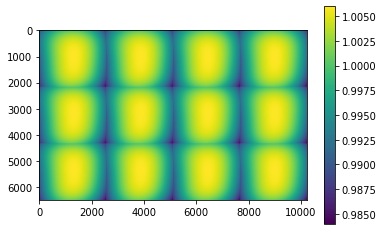

In [30]:
plt.imshow(BigFlatImg)
plt.colorbar()

In [31]:
testBigImg = cv.imread('testFFCImageOrigin.tif', -1).astype('float32')

In [32]:
testBigImg = (testBigImg) / resize(BigFlatImg, (3240, 5120))

In [33]:
cv.imwrite('testMergedImg.tif', (testBigImg * (65535 / testBigImg.max())).astype('uint16'))

True

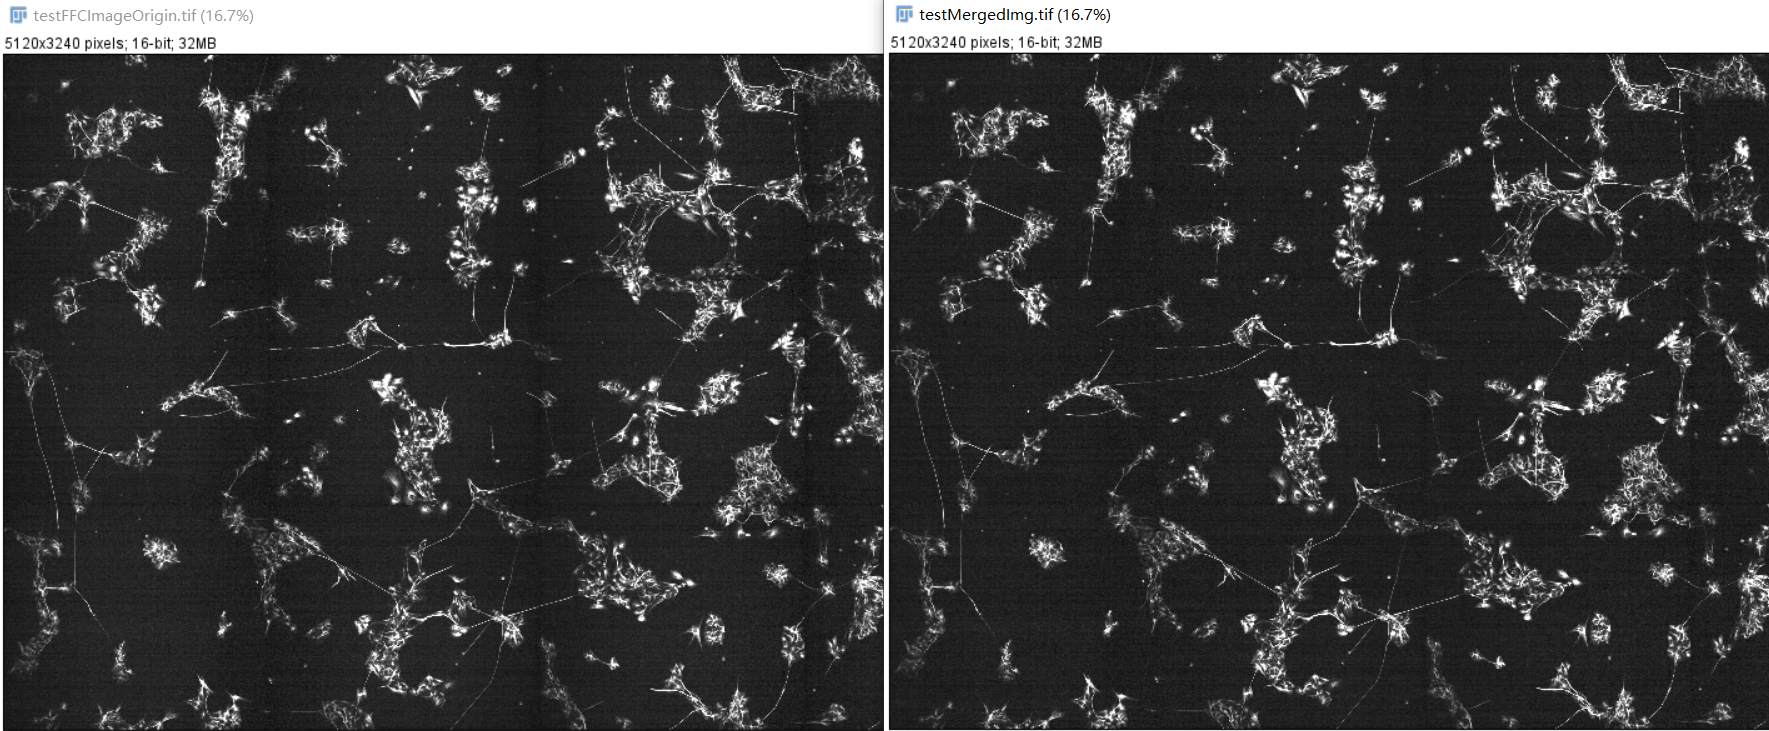

↑ Before/After

In [51]:
model2 = RandomForestRegressor(n_estimators=500, max_depth=5, random_state=0, max_samples=100000)
model2.fit(trainX_Total, trainY_Total)

RandomForestRegressor(max_depth=5, max_samples=100000, n_estimators=500,
                      random_state=0)

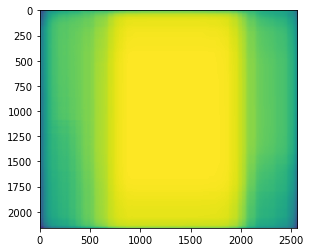

In [52]:
wholeY2 = model2.predict(wholeX)
emptyTemp2 = np.zeros(testImg.shape, 'float32')
emptyTemp2[wholeCoord] = wholeY2
plt.imshow(emptyTemp2)

In [53]:
BigFlatImg2 = np.zeros((3 * 2160, 4 * 2560), dtype = 'float32')
for i in range(len(correctedImgList)):
    ridx = i // 4
    cidx = i % 4
    BigFlatImg2[ridx * 2160 : (ridx + 1) * 2160, cidx * 2560 : (cidx + 1) * 2560] = ((emptyTemp2) / (emptyTemp2.mean()))

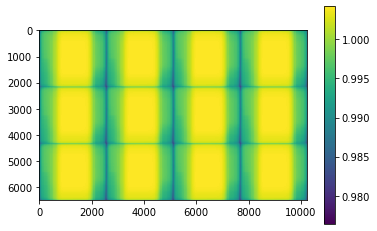

In [54]:
plt.imshow(BigFlatImg2)
plt.colorbar()

In [55]:
testBigImg2 = (testBigImg) / resize(BigFlatImg2, (3240, 5120))

In [56]:
cv.imwrite('testMergedImg2.tif', (testBigImg2 * (65535 / testBigImg2.max())).astype('uint16'))

True

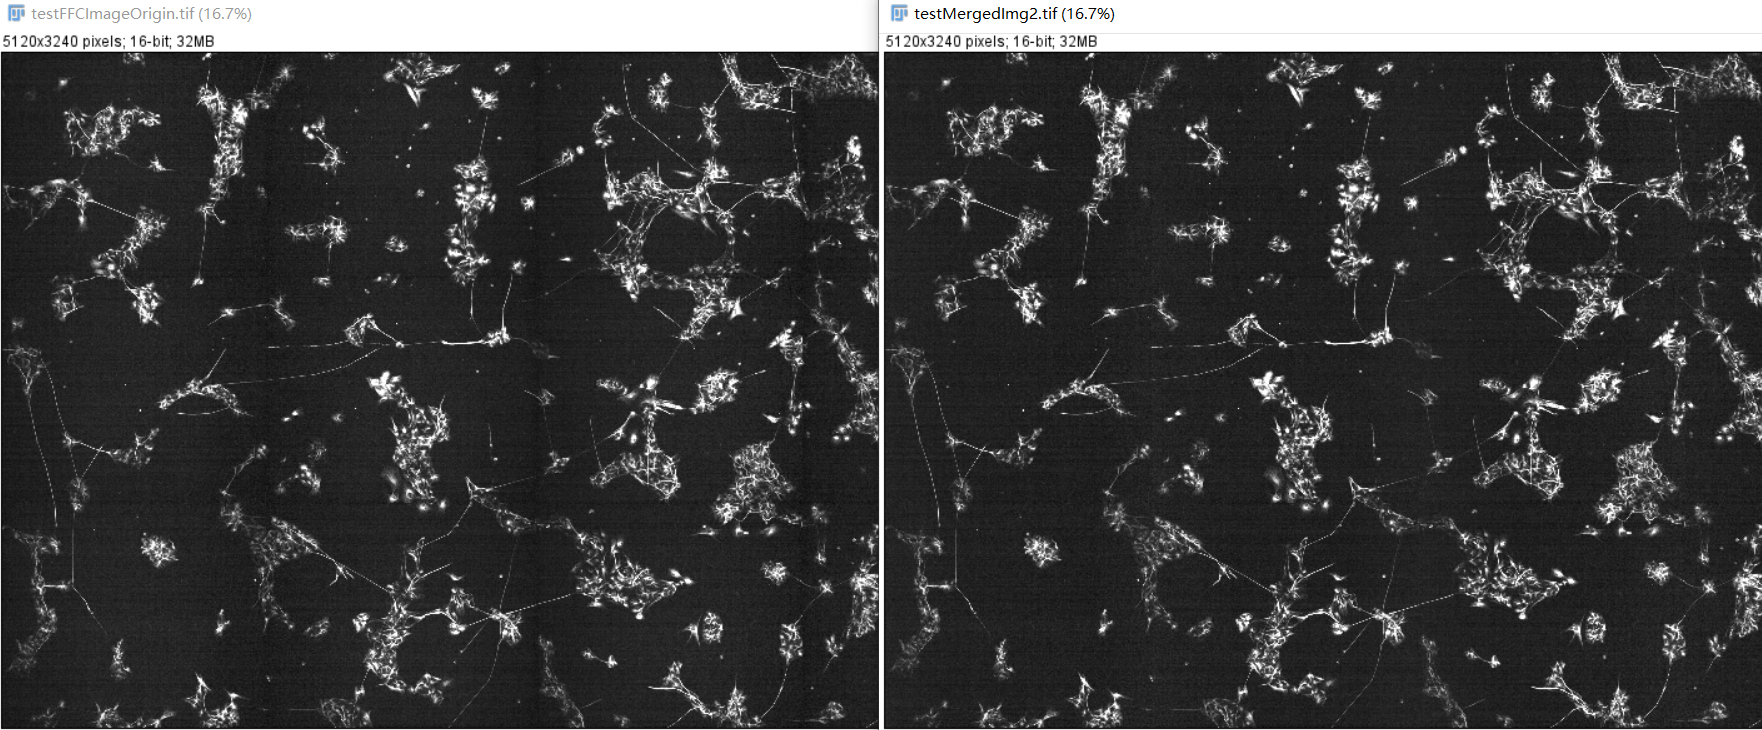

↑Before/After